In [1]:
import os, sys

from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import DataFrame

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [2]:
stack = 'MD657'
_, sec2fn = DataManager.load_sorted_filenames(stack)
first_sec, last_sec = DataManager.load_cropbox(stack)[4:]

# Match histograms between Nissl and Neurotrace

In [8]:
def match_histogram(source, template):
    """
    Returns: 
        s_values (array): unique source values
        interp_t_values (array): unique destination values
    """
    
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return s_values, interp_t_values

In [7]:
# def hist_match(source, template):
#     """
#     Adjust the pixel values of a grayscale image such that its histogram
#     matches that of a target image

#     Arguments:
#     -----------
#         source: np.ndarray
#             Image to transform; the histogram is computed over the flattened
#             array
#         template: np.ndarray
#             Template image; can have different dimensions to source
#     Returns:
#     -----------
#         matched: np.ndarray
#             The transformed output image
#     """
#     # http://stackoverflow.com/a/33047048

#     oldshape = source.shape
#     source = source.ravel()
#     template = template.ravel()

#     # get the set of unique pixel values and their corresponding indices and
#     # counts
#     s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
#                                             return_counts=True)
#     t_values, t_counts = np.unique(template, return_counts=True)

#     # take the cumsum of the counts and normalize by the number of pixels to
#     # get the empirical cumulative distribution functions for the source and
#     # template images (maps pixel value --> quantile)
#     s_quantiles = np.cumsum(s_counts).astype(np.float64)
#     s_quantiles /= s_quantiles[-1]
#     t_quantiles = np.cumsum(t_counts).astype(np.float64)
#     t_quantiles /= t_quantiles[-1]

#     # interpolate linearly to find the pixel values in the template image
#     # that correspond most closely to the quantiles in the source image
#     interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

#     return interp_t_values[bin_idx].reshape(oldshape)

In [9]:
nissl_sections = [sec for sec, fn in sec2fn.iteritems() if not is_invalid(fn) and fn.split('-')[1][0] == 'N' and sec > first_sec and sec < last_sec]
ntb_sections = [sec for sec, fn in sec2fn.iteritems() if not is_invalid(fn) and fn.split('-')[1][0] == 'F' and sec > first_sec and sec < last_sec]

In [10]:
# Generate nissl-nissl pairs.

# compare_pairs = []
# for nissl_sec in nissl_sections:
#     for i in range(1, 10):
#         closest_nissl_sec = nissl_sec + i
#         if closest_nissl_sec in nissl_sections:
#             break
#     compare_pairs.append((nissl_sec, closest_nissl_sec))

In [11]:
# Generate nissl-ntb pairs.

compare_pairs = []
for nissl_sec in nissl_sections:
    for i in range(1, 10):
        closest_ntb_sec = nissl_sec + i
        if closest_ntb_sec in ntb_sections:
            break
    compare_pairs.append((nissl_sec, closest_ntb_sec))

In [12]:
w, h = metadata_cache['image_shape'][stack]

# Same region, different images.

In [ ]:
# Sample the region bbox.

while True:
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    
    region1_x = np.random.randint(0, w-10000, 1)[0]
    region1_y = np.random.randint(0, h-10000, 1)[0]
    region1_w = 5000
    region1_h = 5000
    print region1_x, region1_y, region1_w, region1_h

    tb_region1_xmin = region1_x / 32
    tb_region1_xmax = (region1_x + region1_w) / 32
    tb_region1_ymin = region1_y / 32
    tb_region1_ymax = (region1_y + region1_h) / 32

    if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
    nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
    nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
    nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
        break

In [ ]:
ntb_matched_values_all_examples = []

for nissl_sec, ntb_sec in compare_pairs[:10]:
    
    ntb_im_fp = DataManager.get_image_filepath(stack=stack, section=ntb_sec, version='cropped_16bit', resol='lossless')
    download_from_s3(ntb_im_fp)
    ntb_im = imread(ntb_im_fp)
    ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
    ntb_blue_region1 = 3000 - ntb_blue_region1
    
    ntb_blue_bins = np.arange(0, ntb_blue_region1.max()+2)
    ntb_blue_hist = np.histogram(ntb_blue_region1.flatten(), bins=ntb_blue_bins)[0]
    
    nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
    download_from_s3(nissl_im_fp)
    nissl_im = imread(nissl_im_fp)
    nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))
    
    nissl_gray_bins = np.arange(0, 257)
    nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]
    
    ###############
    
    ntb_region1_hist_matched = hist_match(ntb_blue_region1, nissl_region1)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
    axes[0].imshow(nissl_region1, plt.cm.gray);
    axes[0].set_title('Nissl');
    axes[1].imshow(ntb_region1_hist_matched.astype(np.uint8), plt.cm.gray);
    axes[1].set_title('Neurotrace (histogram matched)');
    plt.show();
    
    ntb_to_nissl = {}
    for ntb_v in ntb_blue_bins[:-1]:
        a = ntb_region1_hist_matched[ntb_blue_region1 == ntb_v]
        if len(a) > 0:
            ntb_to_nissl[ntb_v] = np.unique(a)[0]

    ntb_values = np.arange(0, 5000)
    ntb_matched_values = np.interp(ntb_values, 
                                   [ntb_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())], 
                                   [nissl_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())])
    
    ntb_matched_values_all_examples.append(ntb_matched_values)

    plt.plot(ntb_values, ntb_matched_values);
    plt.xlim([0,5000]);
    plt.ylim([0,256]);
    plt.xlabel('Neurotrace intensity');
    plt.ylabel('Matched nissl intensity');
    plt.show();

In [ ]:
plt.figure(figsize=(10,5));
for a in ntb_matched_values_all_examples:
    plt.plot(ntb_values, a);
plt.xlim([0,5000]);
plt.ylim([0,256]);
plt.xlabel('Neurotrace intensity');
plt.ylabel('Matched nissl intensity');
plt.show();

In [ ]:
# Show that intensities of two modalities are not in exact one-to-one correspondence.

ntb_to_nissl = {}
for ntb_v in ntb_blue_bins[:-1]:
    a = nissl_region1[ntb_blue_region1 == ntb_v]
    if len(a) > 0:
#         ntb_to_nissl[ntb_v] = np.unique(a)[0]
        plt.hist(a, bins=np.arange(256));
        plt.title('%d' % ntb_v);
        plt.xlabel('Nissl intensity');
        plt.xlabel('Distribution of Neurotrace intensities at corresponding pixels.');
        plt.show();

# Explore red and green channels

In [ ]:
from skimage.exposure import rescale_intensity
from skimage.exposure import equalize_hist

In [ ]:
plt.figure(figsize=(20,20));
q = rescale_intensity(ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0],
                     (0, 400))
plt.imshow(q, 
           vmin=0, vmax=q.max(),
          cmap=plt.cm.gray);

In [ ]:
plt.figure(figsize=(20,20));
q = equalize_hist(ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0])
plt.imshow(q, 
           vmin=0, vmax=q.max(),
          cmap=plt.cm.gray);

In [ ]:
plt.figure(figsize=(20,20));
plt.imshow(ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0], 
           vmin=0, vmax=ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0].max(),
          cmap=plt.cm.gray);

In [ ]:
red_imin = 0
red_imax = 75
green_imin = 0
green_imax = 85

In [ ]:
mg_red_intensity_normalized = ntb_matched_values[3000-ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0]].astype(np.uint8)
img_green_intensity_normalized = ntb_matched_values[3000-ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 1]].astype(np.uint8)
img_blue_intensity_normalized = ntb_matched_values[3000-ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]].astype(np.uint8)

In [ ]:
ntb_img_rgb = np.zeros(ntb_blue_region1.shape[:2] + (3,), np.uint8)
ntb_img_rgb[..., 0] = img_red_intensity_normalized
ntb_img_rgb[..., 1] = img_green_intensity_normalized
ntb_img_rgb[..., 2] = img_blue_intensity_normalized

In [ ]:
plt.figure(figsize=(10,10));
plt.imshow(ntb_img_rgb, cmap=plt.cm.gray);

# Same images, different regions. nissl-ntblue

## Parallel

In [ ]:
def f(nissl_sec, ntb_sec):
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    
    for region_id in range(10):

        while True:
            region1_x = np.random.randint(0, w-10000, 1)[0]
            region1_y = np.random.randint(0, h-10000, 1)[0]
            region1_w = 5000
            region1_h = 5000
            print region1_x, region1_y, region1_w, region1_h
            
            tb_region1_xmin = region1_x / 32
            tb_region1_xmax = (region1_x + region1_w) / 32
            tb_region1_ymin = region1_y / 32
            tb_region1_ymax = (region1_y + region1_h) / 32
            
            if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
                break
        
        t = time.time()
        
        ntb_im_fp = DataManager.get_image_filepath(stack=stack, section=ntb_sec, version='cropped_16bit', resol='lossless')
        download_from_s3(ntb_im_fp)
        ntb_im = imread(ntb_im_fp)
        ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
        ntb_blue_region1 = 3000 - ntb_blue_region1

        ntb_blue_bins = np.arange(0, ntb_blue_region1.max()+2)
        ntb_blue_hist = np.histogram(ntb_blue_region1.flatten(), bins=ntb_blue_bins)[0]
        
        sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

        t = time.time()

        nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
        download_from_s3(nissl_im_fp)
        nissl_im = imread(nissl_im_fp)
        nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))

        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]
        
        sys.stderr.write('Load Nissl: %.2f seconds.\n' % (time.time()-t))

        ###############
        
        t = time.time()

        ntb_region1_hist_matched = hist_match(ntb_blue_region1, nissl_region1)

    #     fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
    #     axes[0].imshow(nissl_region1, plt.cm.gray);
    #     axes[0].set_title('Nissl');
    #     axes[1].imshow(ntb_region1_hist_matched.astype(np.uint8), plt.cm.gray);
    #     axes[1].set_title('Neurotrace (histogram matched)');
    #     plt.show();
        ntb_to_nissl = {}
        for ntb_v in ntb_blue_bins[:-1]:
            a = ntb_region1_hist_matched[ntb_blue_region1 == ntb_v]
            if len(a) > 0:
                ntb_to_nissl[ntb_v] = np.unique(a)[0]

        ntb_values = np.arange(0, 5000)
        ntb_matched_values = np.interp(ntb_values, 
                                       [ntb_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())], 
                                       [nissl_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())])

        ntb_matched_values_all_examples_one_section.append(ntb_matched_values)
        region_bboxes_all_examples_one_section.append((region1_x, region1_y, region1_w, region1_h))

        sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))
        
#         ntb_matched_values_all_examples[(nissl_sec, ntb_sec)].append(ntb_matched_values)
#         region_bboxes_all_examples[(nissl_sec, ntb_sec)].append((region1_x, region1_y, region1_w, region1_h))
        
    fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_matched_values.npy' % (ntb_sec, nissl_sec))
    np.save(fp, ntb_matched_values_all_examples_one_section)
    upload_to_s3(fp)

    fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_region_bboxes.npy' % (ntb_sec, nissl_sec))
    np.save(fp, np.asarray(region_bboxes_all_examples_one_section))
    upload_to_s3(fp)

In [ ]:
from multiprocess import Pool

pool = Pool(NUM_CORES/2)
pool.map(lambda (nissl_sec, ntb_sec): f( nissl_sec, ntb_sec), compare_pairs)
pool.close()
pool.join()

## Sequential

In [ ]:
# ntb_matched_values_all_examples = defaultdict(list)
# region_bboxes_all_examples = defaultdict(list)

for nissl_sec, ntb_sec in compare_pairs[37:38]:
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')

    for region_id in range(10):
        
        while True:
            region1_x = np.random.randint(0, w-10000, 1)[0]
            region1_y = np.random.randint(0, h-10000, 1)[0]
            region1_w = 5000
            region1_h = 5000
            print region1_x, region1_y, region1_w, region1_h
            
            tb_region1_xmin = region1_x / 32
            tb_region1_xmax = (region1_x + region1_w) / 32
            tb_region1_ymin = region1_y / 32
            tb_region1_ymax = (region1_y + region1_h) / 32
            
            if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
                break
        
        t = time.time()
        
        ntb_im_fp = DataManager.get_image_filepath(stack=stack, section=ntb_sec, version='cropped_16bit', resol='lossless')
        download_from_s3(ntb_im_fp)
        ntb_im = imread(ntb_im_fp)
        ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
        ntb_blue_region1 = 3000 - ntb_blue_region1

        ntb_blue_bins = np.arange(0, ntb_blue_region1.max()+2)
        ntb_blue_hist = np.histogram(ntb_blue_region1.flatten(), bins=ntb_blue_bins)[0]
    
        sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

        t = time.time()
        
        nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
        download_from_s3(nissl_im_fp)
        nissl_im = imread(nissl_im_fp)
        nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))

        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]

        sys.stderr.write('Load Nissl: %.2f seconds.\n' % (time.time()-t))

        ###############
        
        t = time.time()

        ntb_region1_hist_matched = hist_match(ntb_blue_region1, nissl_region1)

        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
        axes[0].imshow(nissl_region1, plt.cm.gray);
        axes[0].set_title('Nissl');
        axes[1].imshow(ntb_region1_hist_matched.astype(np.uint8), plt.cm.gray);
        axes[1].set_title('Neurotrace (histogram matched)');
        plt.show();

        ntb_to_nissl = {}
        for ntb_v in ntb_blue_bins[:-1]:
            a = ntb_region1_hist_matched[ntb_blue_region1 == ntb_v]
            if len(a) > 0:
                ntb_to_nissl[ntb_v] = np.unique(a)[0]

        ntb_values = np.arange(0, 5000)
        ntb_matched_values = np.interp(ntb_values, 
                                       [ntb_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())], 
                                       [nissl_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())])

    #     ntb_matched_values_all_examples.append(ntb_matched_values)

        ntb_matched_values_all_examples_one_section.append(ntb_matched_values)
        region_bboxes_all_examples_one_section.append((region1_x, region1_y, region1_w, region1_h))
    
#         ntb_matched_values_all_examples[(nissl_sec, ntb_sec)].append(ntb_matched_values)
#         region_bboxes_all_examples[(nissl_sec, ntb_sec)].append((region1_x, region1_y, region1_w, region1_h))
        
        sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))

        
#     fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_matched_values.npy' % (ntb_sec, nissl_sec))
#     np.save(fp, ntb_matched_values_all_examples_one_section)
#     upload_to_s3(fp)

#     fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_region_bboxes.npy' % (ntb_sec, nissl_sec))
#     np.save(fp, np.asarray(region_bboxes_all_examples_one_section))
#     upload_to_s3(fp)
    
    #     plt.plot(ntb_values, ntb_matched_values);
    #     plt.xlim([0,5000]);
    #     plt.ylim([0,256]);
    #     plt.xlabel('Neurotrace intensity');
    #     plt.ylabel('Matched nissl intensity');
    #     plt.show();

# One image pair, different regions (NEW)

In [21]:
# Find the maximal intensity in fluorescent blue channel.

# for fn in metadata_cache['valid_filenames'][stack][::10]:
#     if fn.split('-')[1][0] == 'F':
#         im = DataManager.load_image(stack=stack, fn=fn, version='cropped_16bit', resol='lossless')[..., 2]
#         print fn, im.min(), im.max()

Load NTB: 25.10 seconds.
Load Nissl: 19.43 seconds.
Compute matching: 3.42 seconds.


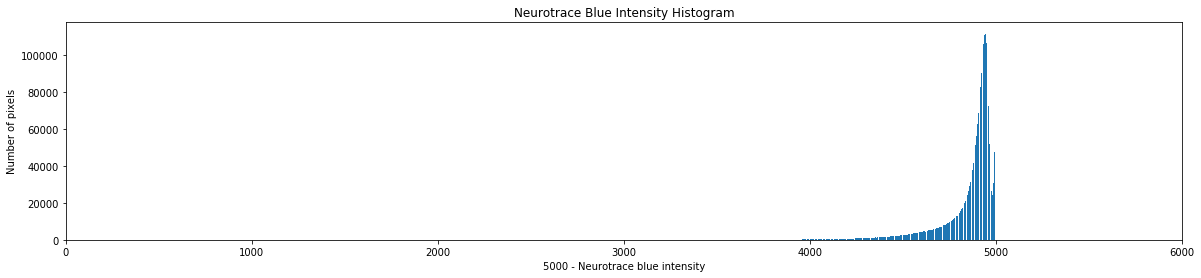

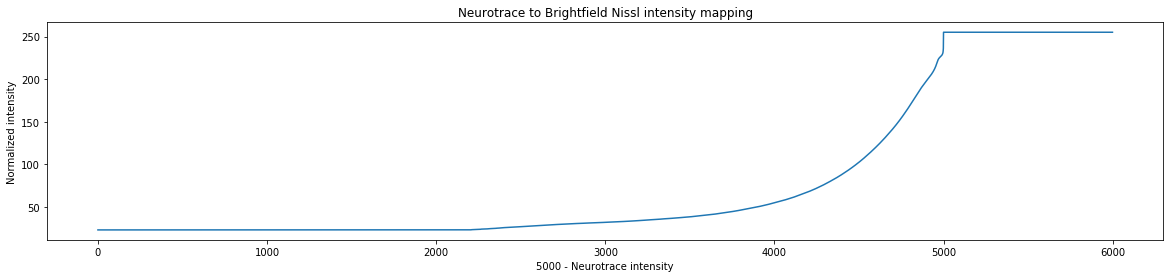

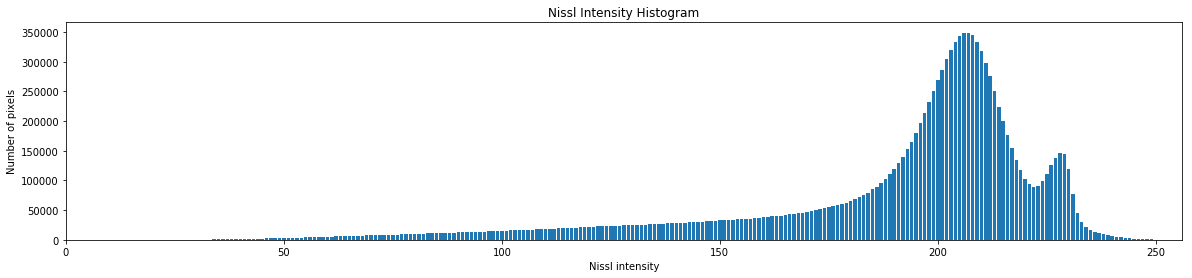

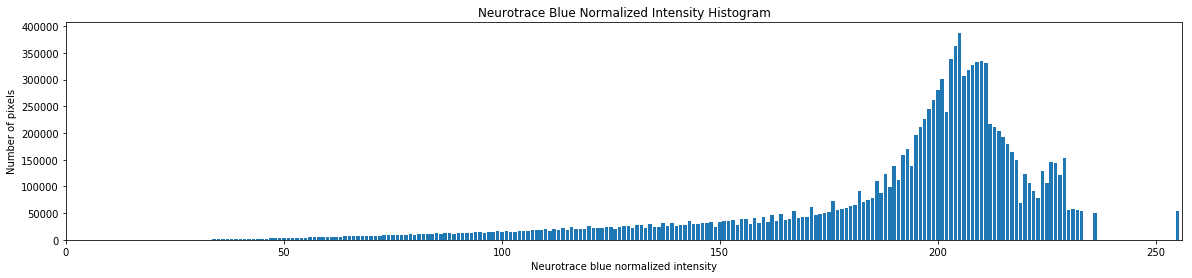

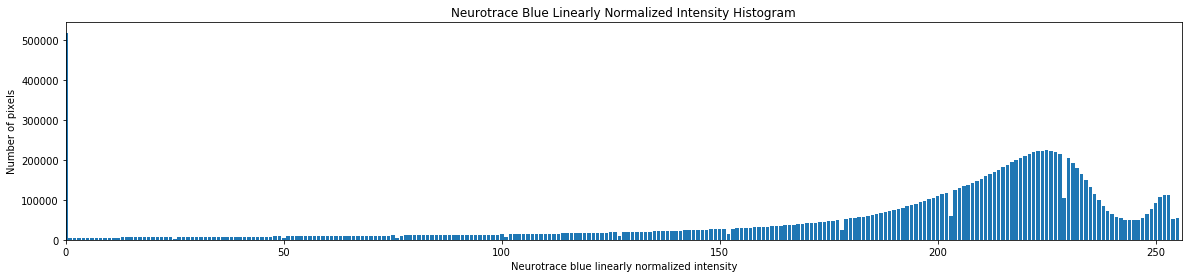

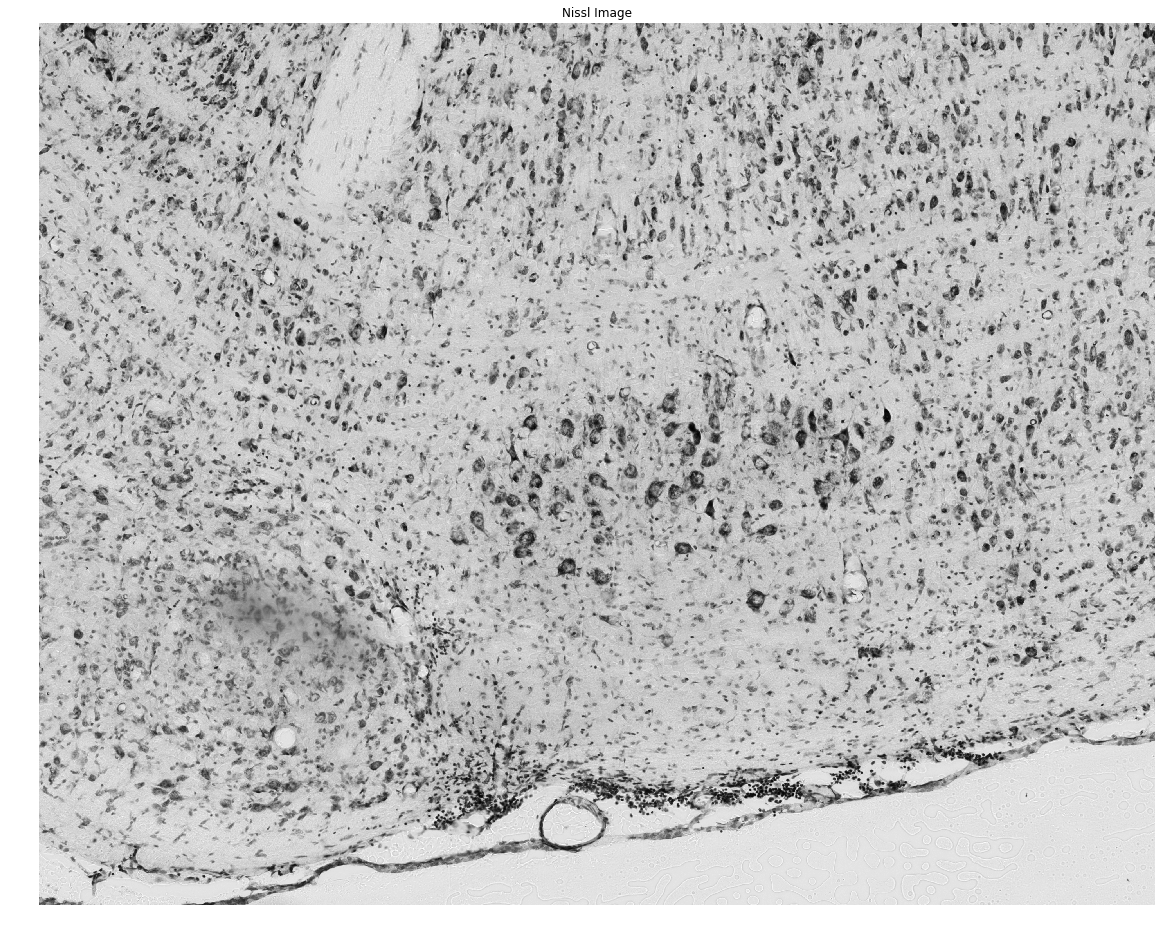

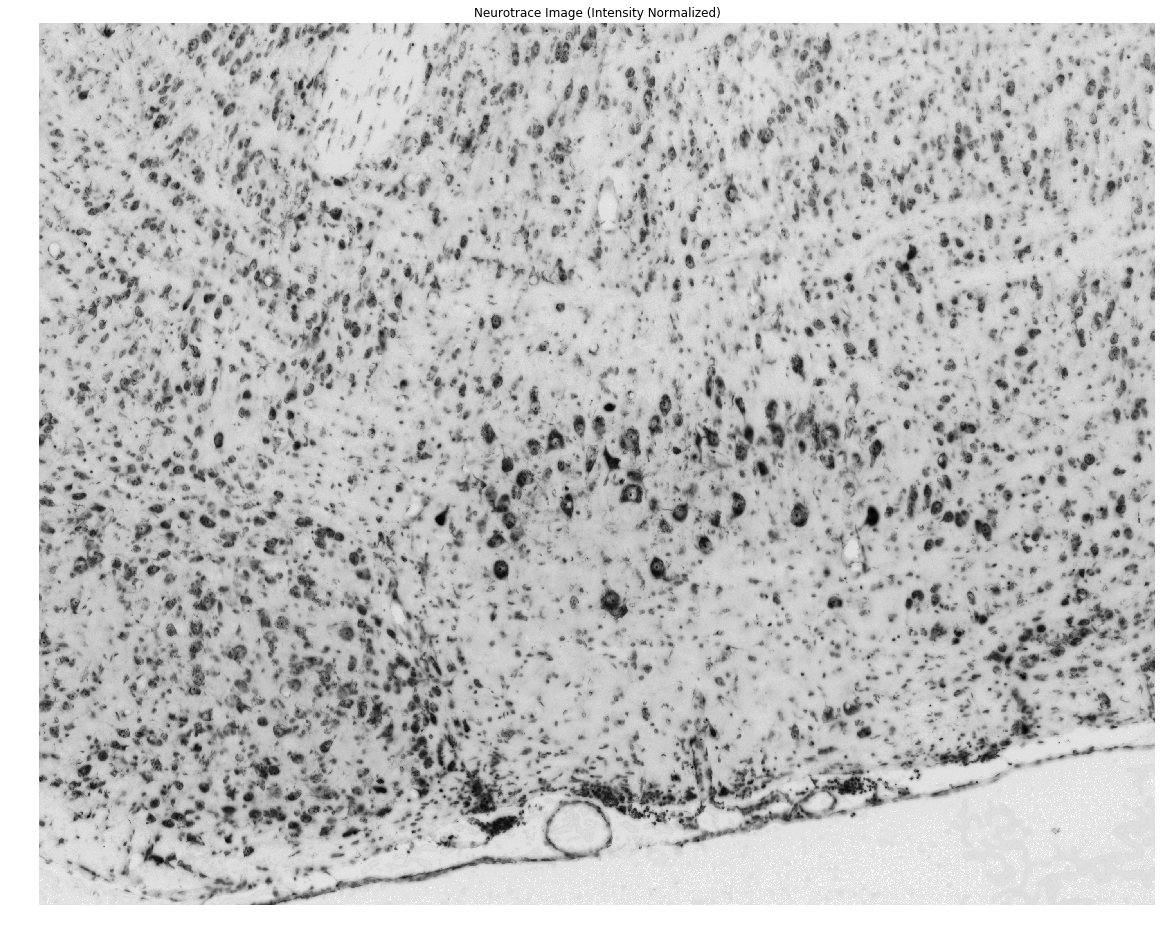

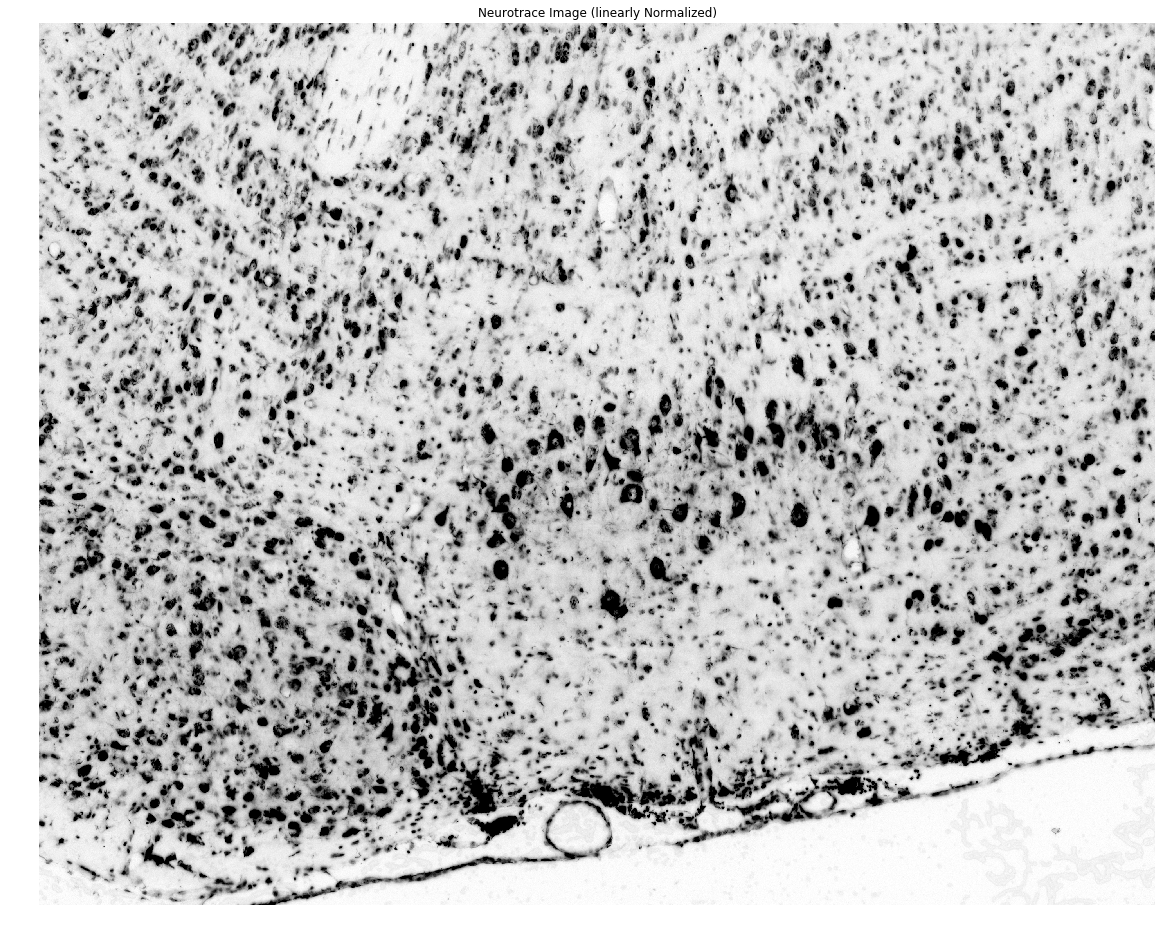

NameError: name 'ntb_fn' is not defined

In [86]:
for nissl_sec, ntb_sec in compare_pairs[35:36]:
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    w, h = metadata_cache['image_shape'][stack]

    t = time.time()
        
    ntb_im = DataManager.load_image(stack=stack, section=ntb_sec, version='cropped_16bit', resol='lossless')

    sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

    t = time.time()

    nissl_im = DataManager.load_image(stack=stack, section=nissl_sec, version='cropped', resol='lossless')

    sys.stderr.write('Load Nissl: %.2f seconds.\n' % (time.time()-t))

#     h, w = nissl_im.shape[:2]
#     for region_id in range(3):
#         while True:
#             region1_w = 5000
#             region1_h = 5000
#             region1_x = np.random.randint(0, w - region1_w, 1)[0]
#             region1_y = np.random.randint(0, h - region1_h, 1)[0]
# #             print region1_x, region1_y, region1_w, region1_h
            
#             tb_region1_xmin = region1_x / 32
#             tb_region1_xmax = (region1_x + region1_w) / 32
#             tb_region1_ymin = region1_y / 32
#             tb_region1_ymax = (region1_y + region1_h) / 32
            
#             if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
#             nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
#             nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
#             nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
#                 break
    
    for region_id in range(1):
        region1_x = 233 * 32
        region1_y = 299 * 32
        region1_w = 124 * 32
        region1_h = 98 * 32
    
        ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
        # Checked a few sections, maximal intensity value in blue channel is less than 5000.
        ntb_blue_region1_inv = 5000 - ntb_blue_region1.astype(np.int)

    #         ntb_blue_inv_bins = np.arange(ntb_blue_region1_inv.min(), ntb_blue_region1_inv.max()+2)
        ntb_blue_inv_bins = np.arange(0, 6000)
        ntb_blue_inv_hist = np.histogram(ntb_blue_region1_inv.flatten(), bins=ntb_blue_inv_bins)[0]

        nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))
        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]        

        ###############

        t = time.time()

        ntb_inv_vals, nissl_vals = match_histogram(ntb_blue_region1_inv, nissl_region1)
    
        ntb_inv_to_nissl_mapping = np.interp(ntb_blue_inv_bins, ntb_inv_vals, nissl_vals)
        
        ntb_matched_values_all_examples_one_section.append(ntb_inv_to_nissl_mapping)
        region_bboxes_all_examples_one_section.append((region1_x, region1_y, region1_w, region1_h))
    
        sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))
        
        ntb_region1_inv_normalized = np.round(ntb_inv_to_nissl_mapping[ntb_blue_region1_inv]).astype(np.uint8)
        
        ntb_blue_inv_normalized_bins = np.arange(0, 257)
        ntb_blue_inv_normalized_hist = np.histogram(ntb_region1_inv_normalized.flatten(), bins=ntb_blue_inv_normalized_bins)[0]
        
        # Linear normalization
        low = 4500
        high = 5000
        ntb_region1_inv_linearNormalized = np.maximum(0, np.minimum(255, 255*(ntb_blue_region1_inv-low)/float(high-low))).astype(np.uint8)
        
        ntb_blue_inv_linearNormalized_bins = np.arange(0, 257)
        ntb_blue_inv_linearNormalized_hist = np.histogram(ntb_region1_inv_linearNormalized.flatten(), bins=ntb_blue_inv_linearNormalized_bins)[0]
        
        # Plot intensity histograms
        
        plt.figure(figsize=(20,4));
        plt.bar(ntb_blue_inv_bins[:-1], ntb_blue_inv_hist);
        plt.xlim([ntb_blue_inv_bins.min(), ntb_blue_inv_bins.max()]);
        plt.xlabel('5000 - Neurotrace blue intensity');
        plt.ylabel('Number of pixels');
        plt.title('Neurotrace Blue Intensity Histogram');
        plt.show();

        plt.figure(figsize=(20,4));
        plt.plot(ntb_blue_inv_bins, ntb_inv_to_nissl_mapping);
        plt.xlabel('5000 - Neurotrace intensity');
        plt.ylabel('Normalized intensity');
        plt.title('Neurotrace to Brightfield Nissl intensity mapping');
        plt.show();
        
        plt.figure(figsize=(20,4));
        plt.bar(nissl_gray_bins[:-1], nissl_gray_hist);
        plt.xlim([nissl_gray_bins.min(), nissl_gray_bins.max()]);
        plt.xlabel('Nissl intensity');
        plt.ylabel('Number of pixels');
        plt.title('Nissl Intensity Histogram');
        plt.show();
        
        plt.figure(figsize=(20,4));
        plt.bar(ntb_blue_inv_normalized_bins[:-1], ntb_blue_inv_normalized_hist);
        plt.xlim([ntb_blue_inv_normalized_bins.min(), ntb_blue_inv_normalized_bins.max()]);
        plt.xlabel('Neurotrace blue normalized intensity');
        plt.ylabel('Number of pixels');
        plt.title('Neurotrace Blue Normalized Intensity Histogram');
        plt.show();
        
        plt.figure(figsize=(20,4));
        plt.bar(ntb_blue_inv_linearNormalized_bins[:-1], ntb_blue_inv_linearNormalized_hist);
        plt.xlim([ntb_blue_inv_linearNormalized_bins.min(), ntb_blue_inv_linearNormalized_bins.max()]);
        plt.xlabel('Neurotrace blue linearly normalized intensity');
        plt.ylabel('Number of pixels');
        plt.title('Neurotrace Blue Linearly Normalized Intensity Histogram');
        plt.show();

        # Two Separate Figures
        
        plt.figure(figsize=(20,20));
        plt.imshow(nissl_region1, plt.cm.gray);
        plt.title('Nissl Image');
        plt.axis('off');
        plt.show();
        
        plt.figure(figsize=(20,20));
        plt.imshow(ntb_region1_inv_normalized, plt.cm.gray);
        plt.title('Neurotrace Image (Intensity Normalized)');
        plt.axis('off');
        plt.show();

        plt.figure(figsize=(20,20));
        plt.imshow(ntb_region1_inv_linearNormalized, plt.cm.gray);
        plt.title('Neurotrace Image (linearly Normalized)');
        plt.axis('off');
        plt.show();

        # Two Subplots
#         fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,10));
#         axes[0].imshow(nissl_region1, plt.cm.gray);
#         axes[0].set_title('Nissl');
#         axes[0].axis('off');
        
#         axes[1].imshow(ntb_region1_inv_normalized, plt.cm.gray);
#         axes[1].set_title('Neurotrace (intensity normalized)');
#         axes[1].axis('off');
        
#         axes[2].imshow(ntb_region1_inv_linearNormalized, plt.cm.gray);
#         axes[2].set_title('Neurotrace (linearly normalized)');
#         axes[2].axis('off');
#         plt.show();

#     fp = os.path.join(DATA_DIR, stack, stack + '_intensity_mapping', '%s_to_%s_intensity_mapping_all_regions.npy' % (ntb_fn, nissl_fn))
#     create_parent_dir_if_not_exists(fp)
#     np.save(fp, np.asarray(ntb_matched_values_all_examples_one_section))
#     upload_to_s3(fp)

#     fp = os.path.join(DATA_DIR, stack, stack + '_intensity_mapping', '%s_to_%s_region_bboxes.npy' % (ntb_fn, nissl_fn))
#     np.save(fp, np.asarray(region_bboxes_all_examples_one_section))
#     upload_to_s3(fp)

#     median_mapping_one_section = np.median(ntb_matched_values_all_examples_one_section, axis=0)
#     fp = DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath(stack=stack, fn=ntb_fn)
#     np.save(fp, np.asarray(median_mapping_one_section))
#     upload_to_s3(fp)

In [ ]:
plt.figure(figsize=(20,20));
ntb_scoremap_viz_fp = DataManager.get_scoremap_viz_filepath(stack=stack, downscale=8, section=ntb_sec, structure='7N', classifier_id=37)
download_from_s3(ntb_scoremap_viz_fp)
ntb_scoremap_viz = imread(ntb_scoremap_viz_fp)[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w][::8]
plt.imshow(ntb_scoremap_viz);
plt.axis('off');
plt.title('7N Score Map of Neurotrace Blue Image');
plt.show();

plt.figure(figsize=(20,20));
nissl_scoremap_viz_fp = DataManager.get_scoremap_viz_filepath(stack=stack, downscale=8, section=nissl_sec, structure='7N', classifier_id=37)
download_from_s3(nissl_scoremap_viz_fp)
nissl_scoremap_viz = imread(nissl_scoremap_viz_fp)[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w][::8]
plt.imshow(nissl_scoremap_viz);
plt.axis('off');
plt.title('7N Score Map of Nissl Image');
plt.show();

In [ ]:
plt.figure(figsize=(10,5));
for a in ntb_matched_values_all_examples:
    plt.plot(ntb_values, a);
plt.xlim([0,5000]);
plt.ylim([0,256]);
plt.xlabel('Neurotrace intensity');
plt.ylabel('Matched nissl intensity');
plt.show();

# Same images, different regions. nissl-nissl

In [ ]:
# nissl2_matched_values_all_examples = defaultdict(list)
# region_bboxes_all_examples = defaultdict(list)

for nissl_sec, nissl2_sec in compare_pairs[45:]:
    
    nissl2_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []

    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    
    for region_id in range(10):

        while True:
            region1_x = np.random.randint(0, w-10000, 1)[0]
            region1_y = np.random.randint(0, h-10000, 1)[0]
            region1_w = 5000
            region1_h = 5000
            print region1_x, region1_y, region1_w, region1_h
            
            tb_region1_xmin = region1_x / 32
            tb_region1_xmax = (region1_x + region1_w) / 32
            tb_region1_ymin = region1_y / 32
            tb_region1_ymax = (region1_y + region1_h) / 32
            
            if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
                break

        t = time.time()
        
        nissl2_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl2_sec, version='cropped_8bit', resol='lossless')
        download_from_s3(nissl2_im_fp)
        nissl2_im = imread(nissl2_im_fp)
        nissl2_region1 = img_as_ubyte(rgb2gray(nissl2_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))

        nissl2_gray_bins = np.arange(0, 257)
        nissl2_gray_hist = np.histogram(nissl2_region1.flatten(), bins=nissl2_gray_bins)[0]
        
        sys.stderr.write('Load Nissl2: %.2f seconds.\n' % (time.time()-t))
        
        t = time.time()

        nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
        download_from_s3(nissl_im_fp)
        nissl_im = imread(nissl_im_fp)
        nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))

        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]
        
        sys.stderr.write('Load Nissl1: %.2f seconds.\n' % (time.time()-t))

        ###############
        
        t = time.time()

        nissl2_region1_hist_matched = hist_match(nissl2_region1, nissl_region1)

    #     fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
    #     axes[0].imshow(nissl_region1, plt.cm.gray);
    #     axes[0].set_title('Nissl1');
    #     axes[1].imshow(nissl2_region1_hist_matched.astype(np.uint8), plt.cm.gray);
    #     axes[1].set_title('Nissl2 (histogram matched to Nissl1)');
    #     plt.show();

        nissl2_to_nissl = {}
        for nissl2_v in nissl2_gray_bins[:-1]:
            a = nissl2_region1_hist_matched[nissl2_region1 == nissl2_v]
            if len(a) > 0:
                nissl2_to_nissl[nissl2_v] = np.unique(a)[0]

        nissl2_values = np.arange(0, 257)
        nissl2_matched_values = np.interp(nissl2_values, 
                                       [nissl2_v for nissl2_v, nissl_v in sorted(nissl2_to_nissl.items())], 
                                       [nissl_v for nissl2_v, nissl_v in sorted(nissl2_to_nissl.items())])
        
        nissl2_matched_values_all_examples_one_section.append(nissl2_matched_values)
        region_bboxes_all_examples_one_section.append((region1_x, region1_y, region1_w, region1_h))

#         nissl2_matched_values_all_examples[(nissl_sec, nissl2_sec)].append(nissl2_matched_values)
#         region_bboxes_all_examples[(nissl_sec, nissl2_sec)].append((region1_x, region1_y, region1_w, region1_h))
        
        sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))

        
    fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'nissl_%d_to_nissl_%d_matched_values.npy' % (nissl2_sec, nissl_sec))
    np.save(fp, nissl2_matched_values_all_examples_one_section)
    upload_to_s3(fp)
        
    fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'nissl_%d_to_nissl_%d_region_bboxes.npy' % (nissl2_sec, nissl_sec))
    np.save(fp,  np.asarray(region_bboxes_all_examples_one_section))
    upload_to_s3(fp)
        
#         plt.plot(nissl2_values, nissl2_matched_values);
#         plt.xlim([0,256]);
#         plt.ylim([0,256]);
#         plt.xlabel('Nissl2 intensity');
#         plt.ylabel('Matched nissl1 intensity');
#         plt.show();

In [ ]:
# plt.figure(figsize=(10,5));
# for a in nissl2_matched_values_all_examples:
#     plt.plot(nissl2_values, a);
# plt.xlim([0,256]);
# plt.ylim([0,256]);
# plt.xlabel('Nissl1 intensity');
# plt.ylabel('Nissl2 matched to Nissl1 intensity');
# plt.show();

In [ ]:
for (nissl_sec, nissl2_sec), matched_values in sorted(nissl2_matched_values_all_examples.items()):
    plt.figure(figsize=(5,5));
    for a in matched_values:
        plt.plot(nissl2_values, a);
    plt.xlim([0,256]);
    plt.ylim([0,256]);
    plt.xlabel('Nissl1 intensity');
    plt.ylabel('Nissl2 matched to Nissl1 intensity');
    plt.title('%d, %d' % (nissl_sec, nissl2_sec));
    plt.axis('equal');
    plt.show();

In [ ]:
plt.bar(nissl_gray_bins[:-1], nissl_gray_hist);
plt.xlabel('Nissl intensity');
plt.show();

plt.bar(ntb_blue_bins[:-1], ntb_blue_hist);
plt.xlabel('Neurotrace blue intensity');
plt.show();

# Whole-image histogram

In [ ]:
info = {}
for sec in range(first_sec, last_sec+1):
    print sec
    fn = sec2fn[sec]
#     im = imread('/home/yuncong/csd395/CSHL_data/MD657_lossy_tif/%s_lossy.jp2.tif' % fn)[..., :3]
    green = im[..., 1]
    gf = green.flatten()
    blue = im[..., 2]
    bf = blue.flatten()
    info[sec] = {'gmax': green.max(),
    'bmax': blue.max(),
    'g99.99': np.percentile(gf, 99.99),
    'g99.999': np.percentile(gf, 99.999),
    'g99.9999': np.percentile(gf, 99.9999),
    'b99.99': np.percentile(bf, 99.99),
    'b99.999': np.percentile(bf, 99.999),
    'b99.9999': np.percentile(bf, 99.9999)}

In [ ]:
d = DataFrame(info).T

In [ ]:
plt.figure();
plt.stem(d['b99.9999'], markerfmt='ro', label='99.9999');
plt.stem(d['b99.999'], markerfmt='go', label='99.999');
plt.stem(d['b99.99'], markerfmt='bo', label='99.99');
plt.title('Blue channel percentile');
plt.legend();

plt.figure();
plt.stem(d['g99.9999'], markerfmt='ro', label='99.9999');
plt.stem(d['g99.999'], markerfmt='go', label='99.999');
plt.stem(d['g99.99'], markerfmt='bo', label='99.99');
plt.title('Green channel percentile');
plt.legend();

# Contrast Stretch Neurotrace Blue

In [ ]:
from skimage.exposure import rescale_intensity

In [ ]:
red = im[..., 0]
green = im[..., 1]
blue = im[..., 2]

In [ ]:
im.shape

In [ ]:
ys = range(1000, im.shape[0]-2000, 2000)
xs = range(1000, im.shape[1]-2000, 2000)

fig, axes = plt.subplots(int(np.ceil(len(ys)*len(xs)/5)), 5, sharex=True, sharey=True, figsize=(20, 10))
axes = axes.flatten()

c = 0
for yi, y in enumerate(ys):
    for xi, x in enumerate(xs):
        b = blue[y:y+1000,x:x+1000]
        count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
        axes[c].bar(left_edges[:-1], np.log(count), width=.1);
        c += 1
        
plt.show();

In [ ]:
ys = range(1000, im.shape[0]-2000, 2000)
xs = range(1000, im.shape[1]-2000, 2000)

fig, axes = plt.subplots(len(ys), len(xs), sharex=True, sharey=True, figsize=(20, 10))

for yi, y in enumerate(ys):
    for xi, x in enumerate(xs):
        b = blue[y:y+1000,x:x+1000]
        count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
        axes[yi][xi].bar(left_edges[:-1], np.log(count), width=.1);
        
plt.show();

In [ ]:
im.shape

In [ ]:
y = 7000
x = 13000
b = blue[y:y+1000,x:x+1000]
count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
plt.bar(left_edges[:-1], np.log(count), width=.1);
plt.show();

In [ ]:
x = 27232
y = 14752
w = 3552
h = 2784

In [ ]:
imin_red = 0
imax_red = 400

In [ ]:
red_out = rescale_intensity(im[y:y+h, x:x+w], in_range=(imin_red, imax_red), out_range=np.uint8)

In [ ]:
im = imread(args.input_fp)[..., :3]
im_out = rescale_intensity(im, in_range=(args.imin, args.imax), out_range=np.uint8)
imsave(args.output_fp, im_out)

In [ ]:
display_image(red_out)

In [ ]:
imin_blue = 0
imax_blue = 400

In [ ]:
blue_out = rescale_intensity(blue[y:y+h, x:x+w], in_range=(imin_blue, imax_blue), out_range=np.uint8)

In [ ]:
display_image(blue_out)

In [ ]:
imin_green = 0
imax_green = 400

In [ ]:
green_out = rescale_intensity(green[y:y+h, x:x+w], in_range=(imin_green, imax_green), out_range=np.uint8)

In [ ]:
display_image(green_out)

In [ ]:
from skimage.exposure import adjust_gamma

In [ ]:
blue_out_gamma = adjust_gamma(blue_out, .5)

In [ ]:
display_image(blue_out_gamma[8000:11000, 8000:11000])

In [ ]:
for sec in range(first_sec, last_sec+1, 5):
# for sec in [132]: # example blue, random region
# for sec in [120]: # has good green
    
    print sec
    fn = sec2fn[sec]
    im = imread('/home/yuncong/csd395/CSHL_data/MD657_lossy_tif/%s_lossy.jp2.tif' % fn)[..., :3]
    
#     plt.figure();
#     count, left_edges = np.histogram(im[...,2].flatten(), bins=np.arange(im[...,2].min(), im[...,2].max()))
#     plt.bar(left_edges[:-1], np.log(count), width=.1);
#     plt.title('Log histogram before contrast stretching');
#     plt.xlabel('Intensity');
#     plt.savefig('/home/yuncong/csd395/ntb_histograms/%(fn)s_pre_stretch.png' % dict(fn=fn))
#     plt.close();
    
    imin = 0
    imax = 68
#     imax = np.percentile(im.flatten(), 99.9999)
#     print imax

#     im_flattened = im.flatten()
#     clip_values = {clip_perc: np.percentile(im_flattened, 100.-clip_perc) for clip_perc in [1e-4, 1e-5, 1e-6]}
    
#     imax = clip_values[1e-5]
#     print imax

    im_out = rescale_intensity(im[...,2], in_range=(imin, imax), out_range=np.uint8)
    
#     plt.figure();
#     count, left_edges = np.histogram(im_out.flatten(), bins=np.arange(im_out.min(), im_out.max()))
#     plt.bar(left_edges[:-1], np.log(count), width=.1);
#     plt.title('Log histogram after contrast stretching, clip=%d' % imax);
#     plt.xlabel('Intensity');
#     plt.savefig('/home/yuncong/csd395/ntb_histograms/%(fn)s_post_stretch.png' % dict(fn=fn))
#     plt.close();
    
    imsave('/home/yuncong/csd395/ntb_histograms/small/%(fn)s_post_stretch.tif' % dict(fn=fn), 
           im_out[::10, ::10].astype(np.uint8))
#     imsave('/home/yuncong/csd395/ntb_histograms/crop/%(fn)s_B.tif' % dict(fn=fn), 
#            im_out[8030:8030+920, 15650:15650+1490].astype(np.uint16)) # random blue region
#     imsave('/home/yuncong/csd395/ntb_histograms/crop/%(fn)s_G.tif' % dict(fn=fn), 
#            im_out[7863:7863+1256, 108440:10844+1303].astype(np.uint8))